# Tutuila SWB2 model code
by Chris Shuler and Aly El-Kadi

Abstract
A water budget approach using SWB2, a soil water-balance model, was applied to the island of Tutuila in American Samoa. The primary objective for the model was to calculate spatially and temporally distributed net-infiltration, which directly controls groundwater recharge rate. This information is essential for assessing water resources availability on islands such as Tutuila where groundwater makes up the majority of drinking and municipal water supplies. Other water budget components such as evapotranspiration, canopy interception, runoff, and mountain front recharge were also quantified with the SWB2 model for average present-day climate conditions. Additionally, the potential effects of future climate change on water resources availability were simulated by integrating dynamically downscaled climate predictions for 2080 to 2099 derived from externally supplied global climate model results. Notable improvements in this model over previously developed Tutuila water budget models include flow-routing based on land topography, inclusion of the mountain front recharge process, and consideration of direct net infiltration from anthropogenic sources such as on-site wastewater units and leaking water delivery lines. Model results indicated approximately 54% of Tutuila’s rainfall infiltrates as groundwater recharge, 8% is lost to canopy evaporation, another 15% is lost to evapotranspiration from soils, and 21% is removed through surface water features as stormflow-runoff. The model was able to simulate these processes with a high-spatial and temporal resolution with a 20 by 20 m grid-cell size, and a daily-resolution output time step. Climate scenarios suggested an increase in net-infiltration of 17 to 27% may be expected by the end of the century depending on the emissions scenario used.

### JUPYTER NOTEBOOK NOTES
This code is written in python (version 3.6.2, |Continuum Analytics, Inc.| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]), and specifically in Jupyter notebook (version 5.6.0) running in an ESRI ArcGis Anaconda environment. Note that an active ArcGis licence is required to use the arcpy service pack, on which this code relies.  

#### Modules and basic model setup parameters

In [20]:
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))

import numpy as np
import arcpy
import os
import sys
from arcpy.sa import *
import pandas as pd
import gdal
from arcpy import env
import shutil
import numpy.ma as ma
import netCDF4 as nc
import subprocess
import re
%matplotlib notebook

arcpy.env.overwriteOutput = True # make sure overwrite files is on

# this is a list of additional functions to load up, as to not clutter the script
%run ../static_inputs/plot_and_table_functions

# projection definition 
sr_project = arcpy.SpatialReference(32702)   # Project dataset into WGS84

Control_File_Name = 'Tutuila_SWB_ver2_controlFile.ctl'

# Modify the control file and model grid wth dimensions of the given run, based on input data file resolution
note reads any random one of the input data grids, this uses dimensions from the rainfall adjustment grid in april, but could be whatever

In [21]:
with open(os.path.join('..', 'input//RF_adj_grids', 'rfadj_apr.asc'), 'r') as dims_file:   # open an ASC file and get the dimenstions out of it 
    dimsfile1 = dims_file.read().splitlines(True)
    x_dim = float(re.findall('\d+', dimsfile1[0])[-1])    
    y_dim = float(re.findall('\d+', dimsfile1[1])[-1])

# cell size as obtained from an input file  
    cel_size = float(re.findall('\d+', dimsfile1[4])[-1])
    

with open(os.path.join('.', Control_File_Name), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', Control_File_Name), 'w') as fout:     # delete first line
    fout.writelines(data[1:])
new_first = 'GRID {} {} 515000. 8409000. {} '.format(x_dim, y_dim, cel_size)  # new first line 
with open(os.path.join('.', Control_File_Name), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)

### copy in needed tabular data from they dynamic inputs folder

In [22]:
# land use lookup file
shutil.copy2(os.path.join("..", "dynamic_inputs", 'Landuse_lookup_maui_mod5.txt') ,os.path.join('..', 'input'))    

# Simple RO : RF ratios file
shutil.copy2(os.path.join("..", "dynamic_inputs", 'RO_Rf_ratios_real_monthly3.txt') ,os.path.join('..', 'input')) # note this is from the simplified version with zone IDs starting at 1

# Rain Fragments file
shutil.copy2(os.path.join("..", "dynamic_inputs", 'Rainfall_fragments_1.prn') ,os.path.join('..', 'input'))  

#  Fragments sequence file
shutil.copy2(os.path.join("..", "dynamic_inputs", 'Sequence_file_1.prn') ,os.path.join('..', 'input')) 

'..\\input\\Sequence_file_1.prn'

#### General coverages and paths. More, basic model setup.

In [23]:
# GIS_FOLDER = os.path.join('..', '..', 'Raw_GIS_Data')

#STD_INPUT_FOLDER = os.path.join('..', '..', 'Std_input')

# path to the grid bound
Grid_shp = os.path.join('..', "static_inputs","Grid_bound", "grid_bound.shp")

if not os.path.exists(os.path.join('..', 'output//')):
    os.makedirs(os.path.join('..', 'output//'))
                        
if not os.path.exists(os.path.join('..', 'output//Figures//')):
    os.makedirs(os.path.join('..', 'output//Figures//'))
fig_path =  (os.path.join('..', 'output//Figures//'))

# set/create GENeral workspace
workspace = os.path.join('..', 'input/General')
if not os.path.exists(workspace):
    os.makedirs(workspace)

# this makes a domain grid of zeros of with cell size
Grid_rast0 =os.path.join(workspace, 'Grid_rast0')
arcpy.PolygonToRaster_conversion(Grid_shp, "zero", Grid_rast0, cell_assignment="MAXIMUM_AREA",  cellsize=cel_size )

# this makes a domain grid of ones of with cell size
Grid_rast1 =os.path.join(workspace, 'Grid_rast1')
arcpy.PolygonToRaster_conversion(Grid_shp, "one", Grid_rast1, cell_assignment="MAXIMUM_AREA",  cellsize=cel_size )

<Result '..\\input\\General\\Grid_rast1'>

# RUN the MODEL (with no MFR) 

In [24]:
# need to always run this before the 1st model run to re-fresh the direct net infiltration coverage to not include the MFR. 
arcpy.Plus_3d(os.path.join('..', 'input/Direct_infiltration',  "A_WL_Rast.asc"), os.path.join('..', 'input/Direct_infiltration', "OSDS_inlf_in.asc"), os.path.join('..', 'input/Direct_infiltration', "temprast"))
arcpy.RasterToASCII_conversion(os.path.join('..', 'input/Direct_infiltration', "temprast"), os.path.join('..', 'input/Direct_infiltration', "Total_inlf_in.asc"))


os.chdir(os.path.join("..", "run"))
# Executable and control file copies
shutil.copy2(os.path.join("." , 'swb2.exe') ,os.path.join('..', 'output')) 
shutil.copy2(os.path.join("." , Control_File_Name) ,os.path.join('..', 'output')) 

os.chdir(os.path.join("..", "output"))
subprocess.call('swb2.exe {}'.format(Control_File_Name), shell=True)
os.chdir(os.path.join("..", "run"))

### Post process output files from first run (note these will be overwritten when the MFR is calculated and factored in

In [25]:
outspace = os.path.join('..', "output", 'post_prcessed_no_MFR')
if not os.path.exists(outspace):
    os.makedirs(outspace)

# procure the row and column lengths from one of the files (for a 20m cell size this is 1750 and 1000, but can change if cell size is modified)
with open(os.path.join('..', 'input//RF_adj_grids', 'rfadj_apr.asc'), 'r') as dims_file:   # open an ASC file and get the dimenstions out of it 
    dimsfile1 = dims_file.read().splitlines(True)
    x_dim = float(re.findall('\d+', dimsfile1[0])[-1])    
    y_dim = float(re.findall('\d+', dimsfile1[1])[-1])
    
# Parameters
Number_of_years = 1
Desired_files = ['actual_et',  'direct_net_infiltation', 'direct_soil_moisture',
             'interception', 'net_infiltration', 'rainfall', 'runoff'] # 'delta_soil_storage',  'irrigation', 
XLLCORNER =      515000.000
YLLCORNER =      8409000.000
CELLSIZE  =      cel_size

# functions
def create_file_reference( component_name ):
    '''
    This is a simple convenience function that will form a path and filename to a
    given water budget component
    '''
    # specify the prefix, path to SWB2 output, timeframe, and resolution
    #output_path = os.path.join(os.getcwd(), "output")
    #prefix      = '\\'
    start_year  = '2000-01-01'
    end_year    = '2000-12-31'
    ncol        = str(int(x_dim))
    nrow        = str(int(y_dim))
    return(  component_name + '__' + start_year + '_' 
          + end_year + '__' + nrow + '_by_' + ncol + '.nc' )

# some other functions to post process stuff

def ncdump(nc_fid):
    '''ncdump outputs dimensions, variables and their attribute information of netCDF4 files'''
    nc_attrs = nc_fid.ncattrs()
    nc_dims = [dim for dim in nc_fid.dimensions]  
    nc_vars = [var for var in nc_fid.variables] 
    return nc_attrs, nc_dims, nc_vars

def writeArrayToArcGrid(arr,filename,xll,yll,cellsize,no_data_val):
    """ this takes a 2d numpy array and turns it into an .asc file """
    arr                = np.copy(arr)
    arr[np.isnan(arr)] = no_data_val
    headerstring       = bytes('NCOLS %d\nNROWS %d\nXLLCENTER %f\nYLLCENTER %f\nCELLSIZE %f\nNODATA_value %f\n' % 
        (arr.shape[1], arr.shape[0], xll, yll, cellsize, no_data_val), 'UTF-8')

    with open(filename,'wb') as fout:
        fout.write(headerstring)
        np.savetxt(fout,arr,'%5.2f')
        

# post process the whole model domain
os.chdir(os.path.join("..", 'output'))  # difficulty in making the path to the file so need to change into the output directory
var = []; tot = []; nclist = []

# Step 1: make list of files that you wish to process 
for i in Desired_files:
    Da_file = create_file_reference(i)
    nclist.append(Da_file)
    
# Step 2 average the daily dimension (len(t) is # of days in the run) to annual 
for i, f in enumerate(nclist):
    nc_data = nc.Dataset(nclist[i])
    nc_attrs, nc_dims, nc_vars = ncdump(nc_data)
    nc_var = nc_vars[3]
    t = nc_data.variables['time'][:]
    y = nc_data.variables['y'][:]
    x = nc_data.variables['x'][:]
    nt = len(t)
    nrow = len(y)
    ncol = len(x)
    rd = np.zeros((nrow, ncol))  # create 0 array of the proper shape
    for day in range(nt):
        r_temp = nc_data.variables[str(nc_var)][day, :, :]
        r_filled = np.ma.filled(r_temp, fill_value=0)    # fills in missing values with 0s (i think) 
        rd = rd+r_filled                                 # sequentially add each day's value in each cell to the empty frame  
    r = rd/nt*365 # to create a one year average from all the years in model.  if want to add leap years add 0.25 
    
    # step 3: write each yearly average array to a .asc file
    keyname = Desired_files[i] 
    writeArrayToArcGrid(r, os.path.join(outspace, "{}_annual.asc".format(keyname)), XLLCORNER, YLLCORNER, CELLSIZE, -999)
    
    # Step 4: calculate total amounts of water in cubic meters per day and create statistics dataframe
    m3pd = ((cel_size**2)*r.sum()*.0254)/365 
    print("{} total  {} [m3/d]".format(keyname, '%.1f' % m3pd))
    var.append(keyname) ; tot.append(m3pd)     # make lists to populate pandas dataframe
    
    nc_data.close()          # make sure to close the nc file so it doesnt stay open

stat_frame = pd.DataFrame({'Variable' : var, 'total_[m3pd]': tot})    #in case you want the max and min#, "Max_[in]": mx, "Min_[in]":mn})
stat_frame["total_[MGD]"] = stat_frame["total_[m3pd]"]/3785.41178       # put things in MGD if interested, 3785.41178 is number of gal in m3      
Precip = list(stat_frame[stat_frame['Variable'] == 'rainfall']['total_[m3pd]'])[0]   # define the amount of calculated Precip
Dir_net_inf = list(stat_frame[stat_frame['Variable'] == 'direct_net_infiltation']['total_[m3pd]'])[0]   # define the amount of calculated infiltration
WB_ins = Precip + Dir_net_inf
stat_frame['pct_of_pcip'] = stat_frame["total_[m3pd]"]/WB_ins
stat_frame.to_csv(os.path.join(outspace, "stats_run7_{}m_cells.csv".format(cel_size)))

# how does the model balance? 
print("WATER BALANCE ratio: outs over ins water budget balanece =  {} % ".format(stat_frame['pct_of_pcip'].sum()-1))   # check water balance

os.chdir(os.path.join("..", 'run'))  # then back out to the home directory

# calculate statistics for individual watersheds
# note, for some reason will not overwrite csvs need to clear them out or recode to make this issue not an issue
#create workspace
outspace_table = os.path.join('..', 'output', 'post_prcessed_no_MFR', "tables")
if not os.path.exists(outspace_table):
    os.makedirs(outspace_table)
sheds = (os.path.join("..", 'static_inputs\\Watersheds\\Runoff_zones_sheds_WGS2S_clip.shp'))

# process each raster layer into a table
for i in (os.listdir(outspace)):
    if i.endswith('.asc'):
        outZSaT = ZonalStatisticsAsTable(sheds, "SHED_NAME", os.path.join(outspace, i), os.path.join(outspace_table, "temptab.dbf"))  # in arc format
        arcpy.TableToTable_conversion(outZSaT, outspace_table, "Table_{}_1.csv".format(i))                                            # take table out of stupid arc format and put into csv format 
        
# this block takes each of the csvs, reads them and calculates water volumnes (m3/d) for each watershed
templist = []
for c in (os.listdir(os.path.join(outspace, "tables"))):
    if c.endswith('.csv'):
        data = pd.read_csv(os.path.join(outspace, "tables", c))
        keyname = c.split("Table_")[1].split("_annual")[0]                   # parameter being worked on
        data[keyname] = (data['MEAN']*.0254/365) * data['AREA'] 
        temp_frame = data[["SHED_NAME", keyname]]
        templist.append(temp_frame)
        
summarry_frame1 = data[['SHED_NAME']]                                        # this is just sticking them all together into one dataframe
for i in templist:
    summarry_frame1 = summarry_frame1.merge(i, on ='SHED_NAME', how='outer')
                          

# that was in actual volumns, now to convert each component into a fraction of the rainfall...
templist2 = []
summarry_frame2 = data[['SHED_NAME']]
for i in summarry_frame1.columns[1:]:
    temp_frame = data[['SHED_NAME']] ; temp_frame[i.split("-")[0]] = summarry_frame1[i]/summarry_frame1['rainfall']
    templist2.append(temp_frame)
    
summarry_frame3 = data[['SHED_NAME']]
for i in templist2:
    summarry_frame3 = summarry_frame3.merge(i, on ='SHED_NAME', how='outer')
                          
summarry_frame_4000 = summarry_frame1.set_index('SHED_NAME')
summarry_frame_4 = summarry_frame_4000.select_dtypes(exclude=['object'])*264.172/1000000   # convert to million gallons per day
    
summarry_frame3.to_csv(os.path.join(outspace, "watershed_summary_stats_percentages.csv"))
summarry_frame1.to_csv(os.path.join(outspace, "watershed_summary_stats_volume_m3pd.csv"))
summarry_frame_4.to_csv(os.path.join(outspace, "watershed_summary_stats_volumes_MGD.csv"))

actual_et total  223881.9 [m3/d]
direct_net_infiltation total  36247.6 [m3/d]
direct_soil_moisture total  1919.3 [m3/d]
interception total  128153.1 [m3/d]
net_infiltration total  843866.0 [m3/d]
rainfall total  1494583.7 [m3/d]
runoff total  355205.6 [m3/d]
WATER BALANCE ratio: outs over ins water budget balanece =  1.014498495425161 % 


c:\program files\arcgis\pro\Resources\ArcToolbox\Scripts\AddGeometryAttributes.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  row = self.Update(row, "START_X", geom.firstPoint.X)


### MFR calculations      

In [26]:
# caclulate how much runoff to dump into the MFR area
outspace_table = os.path.join('..', 'output', 'MFR_calcs', "tables")
if not os.path.exists(outspace_table):
    os.makedirs(outspace_table)

Contributing_area_leo = (os.path.join("..", 'static_inputs\\MFR\\Contributing_MRF_Areas_leone.shp'))
Contributing_area_taf = (os.path.join("..", 'static_inputs\\MFR\\Contributing_MRF_Areas_tafuna.shp'))

outZSaT_leo = ZonalStatisticsAsTable(Contributing_area_leo, "SHED_NAME", os.path.join(outspace, "runoff_annual.asc"), os.path.join(outspace_table, "temptab_leo.dbf"))  # in arc format
arcpy.TableToTable_conversion(outZSaT_leo, outspace_table, "runoff_MFR_leo.csv")                                            # take table out of stupid arc format and put into csv format 
outZSaT_leo = ZonalStatisticsAsTable(Contributing_area_taf, "SHED_NAME", os.path.join(outspace, "runoff_annual.asc"), os.path.join(outspace_table, "temptab_taf.dbf"))  # in arc format
arcpy.TableToTable_conversion(outZSaT_leo, outspace_table, "runoff_MFR_taf.csv") 

data_leo = pd.read_csv(os.path.join(outspace_table, "runoff_MFR_leo.csv"))
data_taf = pd.read_csv(os.path.join(outspace_table, "runoff_MFR_taf.csv"))

data_leo["AreaRunoff_m3pd"] = (data_leo['MEAN']*.0254/365) * data_leo['AREA']    # this is how much runoff is in each MFR contributionzone
data_taf["AreaRunoff_m3pd"] = (data_taf['MEAN']*.0254/365) * data_taf['AREA']    # this is how much runoff is in each MFR contributionzone
tot_MFR_leo = sum(data_leo['AreaRunoff_m3pd'])
tot_MFR_taf = sum(data_taf['AreaRunoff_m3pd'])

# calculate the MFR area and prepare input files
workspace = os.path.join('..', 'input/MFR')
if not os.path.exists(workspace):
    os.makedirs(workspace)

arcpy.Project_management(os.path.join("..", 'static_inputs\\MFR\\MFR_infiltration_area_leone.shp'),  os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), sr_project) 
arcpy.AddField_management(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), "MFR_inch", "DOUBLE")    # add Active cell unit field
arcpy.AddGeometryAttributes_management(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), "AREA")
Total_MFR_area_leo = 0                                                                                                        # stupid block just to calculate the total area
with arcpy.da.SearchCursor(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), "POLY_AREA") as cursor:
    for row in cursor:
        Total_MFR_area_leo = Total_MFR_area_leo + row[0]

arcpy.Project_management(os.path.join("..", 'static_inputs\\MFR\\MFR_infiltration_area_tafuna.shp'),  os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), sr_project) 
arcpy.AddField_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), "MFR_inch", "DOUBLE")    # add Active cell unit field
arcpy.AddGeometryAttributes_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), "AREA")
Total_MFR_area_taf = 0                                                                                                        # stupid block just to calculate the total area
with arcpy.da.SearchCursor(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), "POLY_AREA") as cursor:
    for row in cursor:
        Total_MFR_area_taf = Total_MFR_area_taf + row[0]
        
Inches_of_MFR_across_leo = (tot_MFR_leo/Total_MFR_area_leo/0.0254) * 0.75   # note this 75% number if directly from Izuka 2007
Inches_of_MFR_across_taf = (tot_MFR_taf/Total_MFR_area_taf/0.0254) * 0.75   # note this 75% number if directly from Izuka 2007

arcpy.CalculateField_management(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'), "MFR_inch", "!MFR_inch! + {}".format(Inches_of_MFR_across_leo), "PYTHON3") # calculate the appropriate amount of infitration in inches spread over all MFR zone
arcpy.CalculateField_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'), "MFR_inch", "!MFR_inch! + {}".format(Inches_of_MFR_across_taf), "PYTHON3") # calculate the appropriate amount of infitration in inches spread over all MFR zone

arcpy.Erase_analysis(Grid_shp, os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'),  os.path.join(workspace, 'MFR_infiltration_area_leone_bound.shp'))
arcpy.Erase_analysis(Grid_shp, os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'),  os.path.join(workspace, 'MFR_infiltration_area_tafuna_bound.shp'))

arcpy.Merge_management([os.path.join(workspace, 'MFR_infiltration_area_leone_bound.shp'), os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp')], os.path.join(workspace, 'MFR_infiltration_area_leone_ready.shp'))
arcpy.Merge_management([os.path.join(workspace, 'MFR_infiltration_area_tafuna_bound.shp'), os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp')], os.path.join(workspace, 'MFR_infiltration_area_tafuna_ready.shp'))

arcpy.PolygonToRaster_conversion(os.path.join(workspace, 'MFR_infiltration_area_leone_ready.shp'), "MFR_inch", os.path.join(workspace, "MFR_Rast_L"), cell_assignment="MAXIMUM_AREA",  cellsize=cel_size)
arcpy.PolygonToRaster_conversion(os.path.join(workspace, 'MFR_infiltration_area_tafuna_ready.shp'), "MFR_inch", os.path.join(workspace, "MFR_Rast_T"), cell_assignment="MAXIMUM_AREA",  cellsize=cel_size)

arcpy.RasterToASCII_conversion(os.path.join(workspace, "MFR_Rast_L"), os.path.join(workspace, "MFR_Rast_L.asc"))
arcpy.RasterToASCII_conversion(os.path.join(workspace, "MFR_Rast_T"), os.path.join(workspace, "MFR_Rast_T.asc"))

arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_leone_projected.shp'))
arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_projected.shp'))
arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_leone_bound.shp'))
arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_bound.shp'))
arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_leone_ready.shp'))
arcpy.Delete_management(os.path.join(workspace, 'MFR_infiltration_area_tafuna_ready.shp'))
arcpy.Delete_management(os.path.join(workspace, 'MFR_Rast_L'))
arcpy.Delete_management(os.path.join(workspace, 'MFR_Rast_T'))

# now combine the MFR raster into the other direct infiltration rasters
arcpy.Plus_3d(os.path.join('..', 'input/MFR', "MFR_Rast_L.asc"), os.path.join('..', 'input/Direct_infiltration', "WLOSDrast"), os.path.join('..', 'input/Direct_infiltration', "temprast2"))
arcpy.Plus_3d(os.path.join('..', 'input/MFR', "MFR_Rast_T.asc"), os.path.join('..', 'input/Direct_infiltration', "temprast2"), os.path.join('..', 'input/Direct_infiltration', "temprast3"))
arcpy.RasterToASCII_conversion(os.path.join('..', 'input/Direct_infiltration', "temprast3"), os.path.join('..', 'input/Direct_infiltration', "Total_inlf_in.asc"))

print('MFR leo in MGD is {}'.format(tot_MFR_leo*264.172/1000000))
print('MFR taf in MGD is {}'.format(tot_MFR_taf*264.172/1000000))
print('MFR total in MGD is {}'.format((tot_MFR_leo+tot_MFR_taf)*264.172/1000000))

MFR leo in MGD is 1.8618306670958324
MFR taf in MGD is 5.776636040106395
MFR total in MGD is 7.638466707202228


# Run the Model again, this time including the MFR

In [27]:
# Executable and control file copies
shutil.copy2(os.path.join("." , 'swb2.exe') ,os.path.join('..', 'output')) 
shutil.copy2(os.path.join("." , Control_File_Name) ,os.path.join('..', 'output')) 

os.chdir(os.path.join("..", "output"))
subprocess.call('swb2.exe {}'.format(Control_File_Name), shell=True)
os.chdir(os.path.join("..", "run"))

# Post process the files again, this time with the MFR added 

In [28]:
outspace = os.path.join('..', "output", 'post_prcessed_with_MFR')
if not os.path.exists(outspace):
    os.makedirs(outspace)

# post process the whole model domain
os.chdir(os.path.join("..", 'output'))  # difficulty in making the path to the file so need to change into the output directory
var = []; tot = []; nclist = []

# Step 1: make list of files that you wish to process 
for i in Desired_files:
    Da_file = create_file_reference(i)
    nclist.append(Da_file)
    
# Step 2 average the daily dimension (len(t) is # of days in the run) to annual 
for i, f in enumerate(nclist):
    nc_data = nc.Dataset(nclist[i])
    nc_attrs, nc_dims, nc_vars = ncdump(nc_data)
    nc_var = nc_vars[3]
    t = nc_data.variables['time'][:]
    y = nc_data.variables['y'][:]
    x = nc_data.variables['x'][:]
    nt = len(t)
    nrow = len(y)
    ncol = len(x)
    rd = np.zeros((nrow, ncol))  # create 0 array of the proper shape
    for day in range(nt):
        r_temp = nc_data.variables[str(nc_var)][day, :, :]
        r_filled = np.ma.filled(r_temp, fill_value=0)    # fills in missing values with 0s (i think) 
        rd = rd+r_filled                                 # sequentially add each day's value in each cell to the empty frame  
    r = rd/nt*365 # to create a one year average from all the years in model.  if want to add leap years add 0.25 
    
    # step 3: write each yearly average array to a .asc file
    keyname = Desired_files[i] 
    writeArrayToArcGrid(r, os.path.join(outspace, "{}_annual.asc".format(keyname)), XLLCORNER, YLLCORNER, CELLSIZE, -999)
    
    # Step 4: calculate total amounts of water in cubic meters per day and create statistics dataframe
    m3pd = ((cel_size**2)*r.sum()*.0254)/365 
    print("{} total  {} [m3/d]".format(keyname, '%.1f' % m3pd))
    var.append(keyname) ; tot.append(m3pd)     # make lists to populate pandas dataframe
    
    nc_data.close()          # make sure to close the nc file so it doesnt stay open

stat_frame = pd.DataFrame({'Variable' : var, 'total_[m3pd]': tot})    #in case you want the max and min#, "Max_[in]": mx, "Min_[in]":mn})
stat_frame["total_[MGD]"] = stat_frame["total_[m3pd]"]/3785.41178       # put things in MGD if interested, 3785.41178 is number of gal in m3      
Precip = list(stat_frame[stat_frame['Variable'] == 'rainfall']['total_[m3pd]'])[0]   # define the amount of calculated Precip
Dir_net_inf = list(stat_frame[stat_frame['Variable'] == 'direct_net_infiltation']['total_[m3pd]'])[0]   # define the amount of calculated infiltration
WB_ins = Precip + Dir_net_inf
stat_frame['pct_of_pcip'] = stat_frame["total_[m3pd]"]/WB_ins
stat_frame.to_csv(os.path.join(outspace, "stats_run7_{}m_cells.csv".format(cel_size)))

# how does the model balance? 
print("WATER BALANCE ratio: outs over ins water budget balanece =  {} % ".format(stat_frame['pct_of_pcip'].sum()-1))   # check water balance

os.chdir(os.path.join("..", 'run'))  # then back out to the home directory

# calculate statistics for individual watersheds
# note, for some reason will not overwrite csvs need to clear them out or recode to make this issue not an issue
#create workspace
outspace_table = os.path.join('..', 'output', 'post_prcessed_with_MFR', "tables")
if not os.path.exists(outspace_table):
    os.makedirs(outspace_table)
sheds = (os.path.join("..", 'static_inputs\\Watersheds\\Runoff_zones_sheds_WGS2S_clip.shp'))

# process each raster layer into a table
for i in (os.listdir(outspace)):
    if i.endswith('.asc'):
        outZSaT = ZonalStatisticsAsTable(sheds, "SHED_NAME", os.path.join(outspace, i), os.path.join(outspace_table, "temptab.dbf"))  # in arc format
        arcpy.TableToTable_conversion(outZSaT, outspace_table, "Table_{}_1.csv".format(i))                                            # take table out of stupid arc format and put into csv format 
        
# this block takes each of the csvs, reads them and calculates water volumnes (m3/d) for each watershed
templist = []
for c in (os.listdir(os.path.join(outspace, "tables"))):
    if c.endswith('.csv'):
        data = pd.read_csv(os.path.join(outspace, "tables", c))
        keyname = c.split("Table_")[1].split("_annual")[0]                   # parameter being worked on
        data[keyname] = (data['MEAN']*.0254/365) * data['AREA'] 
        temp_frame = data[["SHED_NAME", keyname]]
        templist.append(temp_frame)
        
summarry_frame1 = data[['SHED_NAME']]                                        # this is just sticking them all together into one dataframe
for i in templist:
    summarry_frame1 = summarry_frame1.merge(i, on ='SHED_NAME', how='outer')
                          

# that was in actual volumns, now to convert each component into a fraction of the rainfall...
templist2 = []
summarry_frame2 = data[['SHED_NAME']]
for i in summarry_frame1.columns[1:]:
    temp_frame = data[['SHED_NAME']] ; temp_frame[i.split("-")[0]] = summarry_frame1[i]/summarry_frame1['rainfall']
    templist2.append(temp_frame)
    
summarry_frame3 = data[['SHED_NAME']]
for i in templist2:
    summarry_frame3 = summarry_frame3.merge(i, on ='SHED_NAME', how='outer')
                          
summarry_frame_4000 = summarry_frame1.set_index('SHED_NAME')
summarry_frame_4 = summarry_frame_4000.select_dtypes(exclude=['object'])*264.172/1000000   # convert to million gallons per day
    
summarry_frame3.to_csv(os.path.join(outspace, "watershed_summary_stats_percentages.csv"))
summarry_frame1.to_csv(os.path.join(outspace, "watershed_summary_stats_volume_m3pd.csv"))
summarry_frame_4.to_csv(os.path.join(outspace, "watershed_summary_stats_volumes_MGD.csv"))

actual_et total  223881.9 [m3/d]
direct_net_infiltation total  57461.2 [m3/d]
direct_soil_moisture total  1919.3 [m3/d]
interception total  128153.1 [m3/d]
net_infiltration total  865079.6 [m3/d]
rainfall total  1494583.7 [m3/d]
runoff total  355205.6 [m3/d]
WATER BALANCE ratio: outs over ins water budget balanece =  1.0143003274067683 % 


c:\program files\arcgis\pro\Resources\ArcToolbox\Scripts\AddGeometryAttributes.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "<WorkspaceFactory>SDE",


## Plot results


reading in ..\output\post_prcessed_with_MFR\actual_et_annual.asc into numpy array...
creating a grid of xy coordinates in the original projection...


<IPython.core.display.Javascript object>


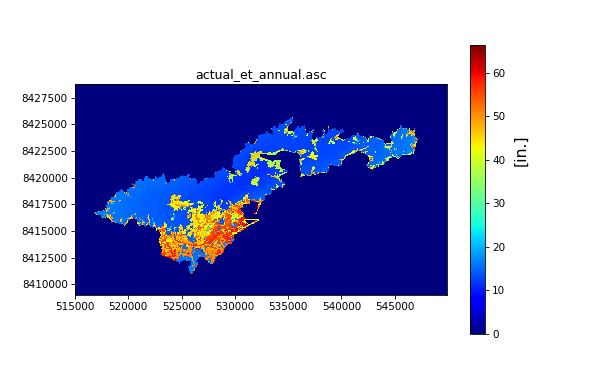


reading in ..\output\post_prcessed_with_MFR\direct_net_infiltation_annual.asc into numpy array...
creating a grid of xy coordinates in the original projection...


<IPython.core.display.Javascript object>


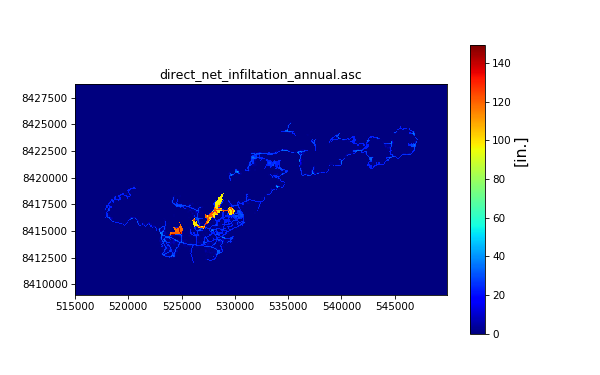


reading in ..\output\post_prcessed_with_MFR\direct_soil_moisture_annual.asc into numpy array...
creating a grid of xy coordinates in the original projection...


<IPython.core.display.Javascript object>


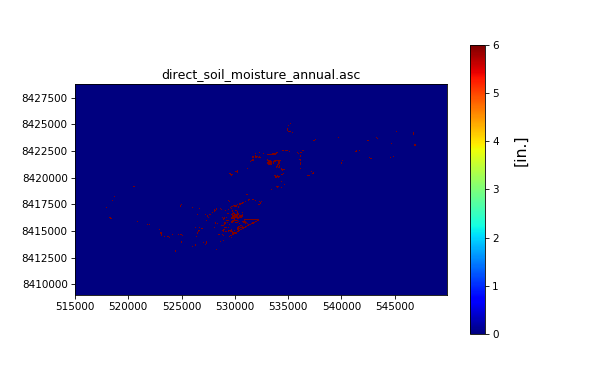


reading in ..\output\post_prcessed_with_MFR\interception_annual.asc into numpy array...
creating a grid of xy coordinates in the original projection...


<IPython.core.display.Javascript object>


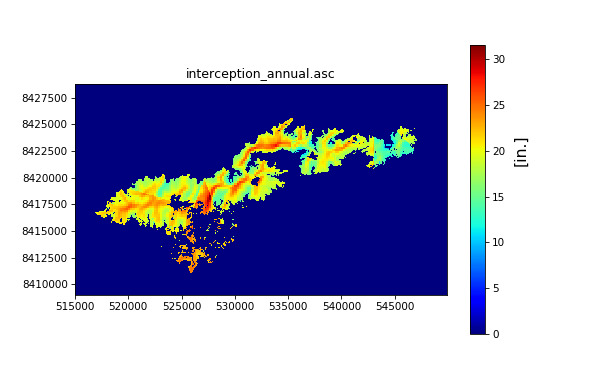


reading in ..\output\post_prcessed_with_MFR\net_infiltration_annual.asc into numpy array...
creating a grid of xy coordinates in the original projection...


<IPython.core.display.Javascript object>


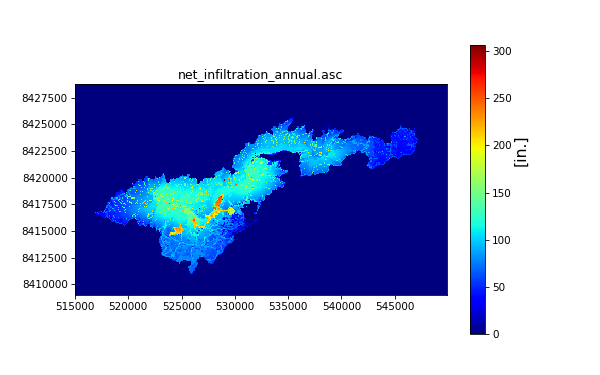


reading in ..\output\post_prcessed_with_MFR\rainfall_annual.asc into numpy array...
creating a grid of xy coordinates in the original projection...


<IPython.core.display.Javascript object>


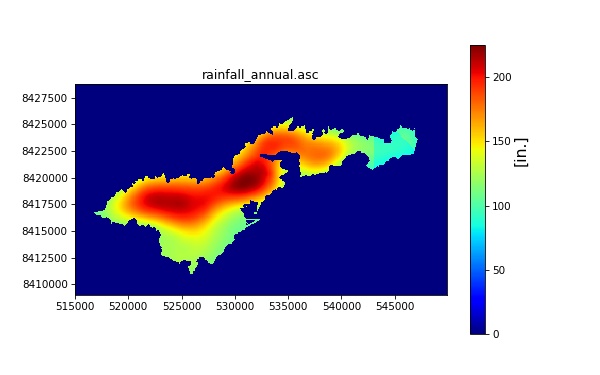


reading in ..\output\post_prcessed_with_MFR\runoff_annual.asc into numpy array...
creating a grid of xy coordinates in the original projection...


<IPython.core.display.Javascript object>


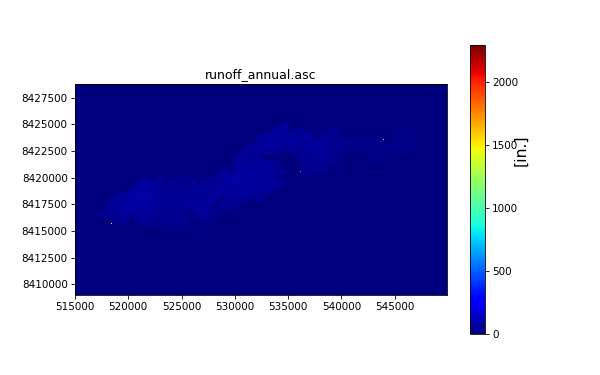

In [30]:
for a in (os.listdir(outspace)):
    if a.endswith('.asc'):
        rfs_data, rfs_gt, rfs_proj, rfs_xy    = read_raster(os.path.join(outspace, a))
        make_plot( x=rfs_xy[0], y=rfs_xy[1], var=rfs_data, discrete=True,  title=a, barlabel='[in.]')
        plt.savefig(os.path.join(fig_path, "Map_of_{},_at{}m.png".format(a, cel_size)), dpi = 300)
       